In [3]:
import sys

In [4]:
# update boto3 and sagemaker to ensure latest SDK version
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install --upgrade boto3
!{sys.executable} -m pip install --upgrade sagemaker
!{sys.executable} -m pip install torch
!{sys.executable} -m pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 891.9 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 38.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 10.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 42.2 MB/s eta 0:00:0000:0100:01


In [5]:
from torchvision import datasets, transforms
from sagemaker.session import Session
from sagemaker.experiments.run import Run, load_run
from sagemaker.utils import unique_name_from_base
import torch
import os
import sys
import logging
from IPython.display import set_matplotlib_formats
from matplotlib import pyplot as plt

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))


experiment_name = unique_name_from_base("local-experiment-example")
run_name = "experiment-run"
print(experiment_name)

INFO:matplotlib.font_manager:generated new fontManager


local-experiment-example-1673147794-d9e8


### Download the dataset


In [6]:
# download the dataset
# this will not only download data to ./mnist folder, but also load and transform (normalize) them
datasets.MNIST.urls = [
    "https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/MNIST/train-images-idx3-ubyte.gz",
    "https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/MNIST/train-labels-idx1-ubyte.gz",
    "https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/MNIST/t10k-images-idx3-ubyte.gz",
    "https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/MNIST/t10k-labels-idx1-ubyte.gz",
]

train_set = datasets.MNIST(
    "mnist_data",
    train=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    ),
    download=True,
)

test_set = datasets.MNIST(
    "mnist_data",
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    ),
    download=True,
)


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw




Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw




Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw




Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [8]:
%matplotlib inline

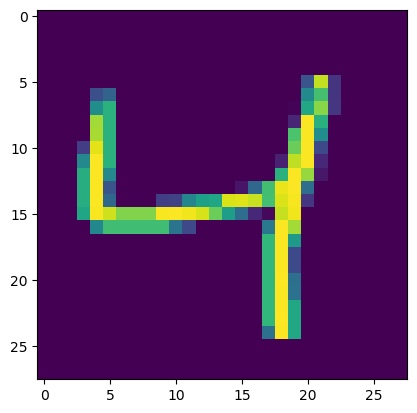

In [9]:
plt.imshow(train_set.data[2].numpy())

### Create experiment and log dataset information


In [10]:
%%time
# create an experiment and start a new run
with Run(experiment_name=experiment_name, run_name=run_name, sagemaker_session=Session()) as run:
    run.log_parameters(
        {"num_train_samples": len(train_set.data), "num_test_samples": len(test_set.data)}
    )
    for f in os.listdir(train_set.raw_folder):
        print("Logging", train_set.raw_folder + "/" + f)
        run.log_file(train_set.raw_folder + "/" + f, name=f, is_output=False)


Logging mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Logging mnist_data/MNIST/raw/train-images-idx3-ubyte
Logging mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz
Logging mnist_data/MNIST/raw/t10k-images-idx3-ubyte
Logging mnist_data/MNIST/raw/t10k-labels-idx1-ubyte
Logging mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz
Logging mnist_data/MNIST/raw/train-images-idx3-ubyte.gz
Logging mnist_data/MNIST/raw/train-labels-idx1-ubyte
CPU times: user 654 ms, sys: 384 ms, total: 1.04 s
Wall time: 2.91 s


### Create Model

In [11]:
# Based on https://github.com/pytorch/examples/blob/master/mnist/main.py
class Net(torch.nn.Module):
    def __init__(self, hidden_channels, kernel_size, drop_out):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, hidden_channels, kernel_size=kernel_size)
        self.conv2 = torch.nn.Conv2d(hidden_channels, 20, kernel_size=kernel_size)
        self.conv2_drop = torch.nn.Dropout2d(p=drop_out)
        self.fc1 = torch.nn.Linear(320, 50)
        self.fc2 = torch.nn.Linear(50, 10)

    def forward(self, x):
        x = torch.nn.functional.relu(torch.nn.functional.max_pool2d(self.conv1(x), 2))
        x = torch.nn.functional.relu(
            torch.nn.functional.max_pool2d(self.conv2_drop(self.conv2(x)), 2)
        )
        x = x.view(-1, 320)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.nn.functional.log_softmax(x, dim=1)

In [12]:
def log_performance(model, data_loader, device, epoch, run, metric_type="Test"):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += torch.nn.functional.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
    loss /= len(data_loader.dataset)
    accuracy = 100.0 * correct / len(data_loader.dataset)
    # log metrics
    run.log_metric(name=metric_type + ":loss", value=loss, step=epoch)
    run.log_metric(name=metric_type + ":accuracy", value=accuracy, step=epoch)


def train_model(
    run, train_set, test_set, data_dir="mnist_data", optimizer="sgd", epochs=10, hidden_channels=10
):
    """
    Function that trains the CNN classifier to identify the MNIST digits.
    Args:
        run (sagemaker.experiments.run.Run): SageMaker Experiment run object
        train_set (torchvision.datasets.mnist.MNIST): train dataset
        test_set (torchvision.datasets.mnist.MNIST): test dataset
        data_dir (str): local directory where the MNIST datasource is stored
        optimizer (str): the optimization algorthm to use for training your CNN
                         available options are sgd and adam
        epochs (int): number of complete pass of the training dataset through the algorithm
        hidden_channels (int): number of hidden channels in your model
    """

    # log the parameters of your model
    run.log_parameter("device", "cpu")
    run.log_parameters(
        {
            "data_dir": data_dir,
            "optimizer": optimizer,
            "epochs": epochs,
            "hidden_channels": hidden_channels,
        }
    )

    # train the model on the CPU (no GPU)
    device = torch.device("cpu")

    # set the seed for generating random numbers
    torch.manual_seed(42)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000, shuffle=True)
    model = Net(hidden_channels, kernel_size=5, drop_out=0.5).to(device)
    model = torch.nn.DataParallel(model)
    momentum = 0.5
    lr = 0.01
    log_interval = 100
    if optimizer == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs + 1):
        print("Training Epoch:", epoch)
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader, 1):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = torch.nn.functional.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        log_performance(model, train_loader, device, epoch, run, "Train")
        log_performance(model, test_loader, device, epoch, run, "Test")
    # log confusion matrix
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.max(1, keepdim=True)[1]
            run.log_confusion_matrix(target, pred, "Confusion-Matrix-Test-Data")

In [13]:
%%time
with load_run(
    experiment_name=experiment_name, run_name=run_name, sagemaker_session=Session()
) as run:
    train_model(
        run=run,
        train_set=train_set,
        test_set=test_set,
        epochs=5,
        hidden_channels=2,
        optimizer="adam",
    )

INFO:sagemaker.experiments.run:The run (experiment-run) under experiment (local-experiment-example-1673147794-d9e8) already exists. Loading it. Note: sagemaker.experiments.load_run is recommended to use when the desired run already exists.


Training Epoch: 1
Training Epoch: 2
Training Epoch: 3
Training Epoch: 4
Training Epoch: 5
CPU times: user 4min 38s, sys: 1.92 s, total: 4min 40s
Wall time: 2min 9s


### Run multiple experiments

In [14]:
%%time
# define the list of parameters to train the model with
num_hidden_channel_param = [5, 10]
optimizer_param = ["adam", "sgd"]
run_id = 0
# train the model using SageMaker Experiments to track the model parameters,
# metrics and performance
sm_session = Session()
for i, num_hidden_channel in enumerate(num_hidden_channel_param):
    for k, optimizer in enumerate(optimizer_param):
        run_id += 1
        run_name = "experiment-run-" + str(run_id)
        print(run_name)
        print(
            f"Training model with: {num_hidden_channel} hidden channels and {optimizer} as optimizer"
        )
        # Defining an experiment run for each model training run
        with Run(
            experiment_name=experiment_name, run_name=run_name, sagemaker_session=sm_session
        ) as run:
            train_model(
                run=run,
                train_set=train_set,
                test_set=test_set,
                epochs=5,
                hidden_channels=num_hidden_channel,
                optimizer=optimizer,
            )

experiment-run-1
Training model with: 5 hidden channels and adam as optimizer
Training Epoch: 1
Training Epoch: 2
Training Epoch: 3
Training Epoch: 4
Training Epoch: 5
experiment-run-2
Training model with: 5 hidden channels and sgd as optimizer
Training Epoch: 1
Training Epoch: 2
Training Epoch: 3
Training Epoch: 4
Training Epoch: 5
experiment-run-3
Training model with: 10 hidden channels and adam as optimizer
Training Epoch: 1
Training Epoch: 2
Training Epoch: 3
Training Epoch: 4
Training Epoch: 5
experiment-run-4
Training model with: 10 hidden channels and sgd as optimizer
Training Epoch: 1
Training Epoch: 2
Training Epoch: 3
Training Epoch: 4
Training Epoch: 5
CPU times: user 20min 9s, sys: 7.51 s, total: 20min 16s
Wall time: 9min 2s
